# Multiobjective optimization

So far, we have only looked at one objective: amount of gold at the dig site. 
But Ms. Dixon now points out that she can find more gold per day if the dig site is close to the 
camp, so she can get back and forth more quickly. If we knew how much gold was at each site, how 
long it would take to dig up, the travel time and the cost of travel it would in theory be 
possible to optimize a single objective: increase in wealth per day.
However, after some discussion, we find out that we cannot reliably make such combined objective 
function. It relies on too many uncertain guestimates. The uncertainties will compound and bias 
our search in an undesirableble way. 

What we can agree on is that, for two dig sites $A$ and $B$:
* If $A$ is closer to the camp than $B$, while not having a lower gold content than $B$, $A$ is preferred.
* If $A$ has a higher gold content than $B$, while not being farther from the camp than $B$, $A$ is preferred.

In either case, we say that $A$ dominates $B$. If we make a `ProcessOptimizer` that optimizes two objectives, it tries to find the points that aren't dominated by any other dig sites. These are the sites we can't immediately rule out as the best places to dig. Such sites are called Pareto efficient, and the set of all such sites is called the Pareto front.

We start by loading `ModelSystem`s for how much gold is present at a dig site, and how far
it is from the camp situated at $(4, 10)$.

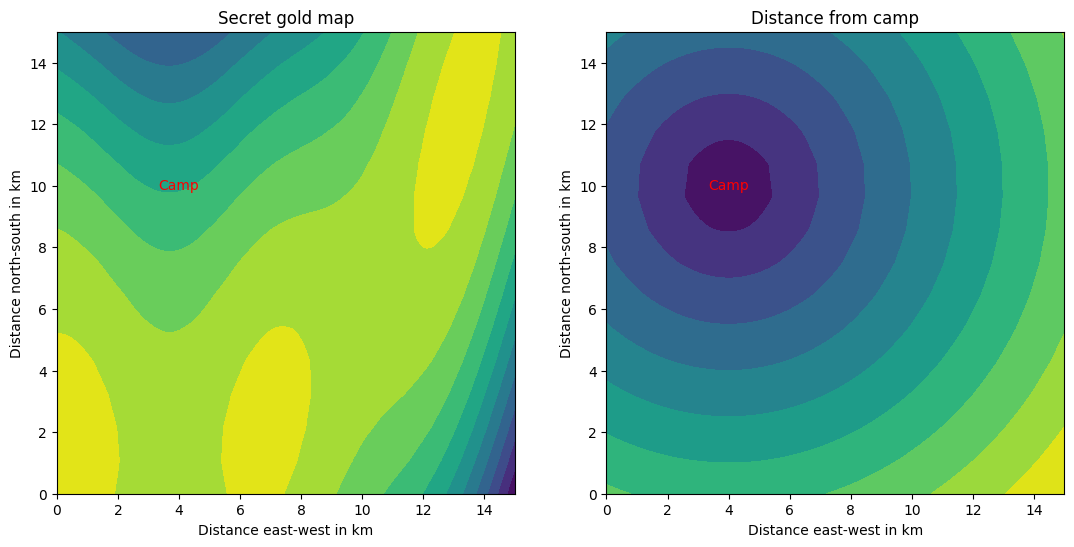

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import ProcessOptimizer
from ProcessOptimizer.model_systems import get_model_system

gold_model_system = get_model_system('gold_map')
distance_model_system = get_model_system('distance_map', camp_coordinates=(4,10))
bounds = gold_model_system.space.bounds


x_list = np.linspace(bounds[0][0],bounds[0][1],100)
y_list = np.linspace(bounds[1][0],bounds[1][1],15,100)
(x_mesh,y_mesh) = np.meshgrid(x_list,y_list)
gold_mesh = [[-gold_model_system.get_score((x,y)) for (x,y) in zip(x_vec,y_vec)] 
              for (x_vec,y_vec) in zip(x_mesh,y_mesh)]

figure = plt.figure()
figure.set_size_inches(13,6)
gold_plot = figure.add_subplot(1,2,1)
distance_plot = figure.add_subplot(1,2,2)
plot = gold_plot.contourf(x_mesh,y_mesh,gold_mesh,10)
plot.axes.set_xlabel("Distance east-west in km")
plot.axes.set_ylabel("Distance north-south in km")
plot.axes.set_title("Secret gold map")
gold_plot.text(4,10,"Camp",color='red', horizontalalignment='center', verticalalignment='center')

distance_mesh = [[distance_model_system.get_score((x,y)) for (x,y) in zip(x_vec,y_vec)] 
              for (x_vec,y_vec) in zip(x_mesh,y_mesh)]
plot = distance_plot.contourf(x_mesh,y_mesh,distance_mesh,10)
plot.axes.set_xlabel("Distance east-west in km")
plot.axes.set_ylabel("Distance north-south in km")
plot.axes.set_title("Distance from camp")
distance_plot.text(4,10,"Camp",color='red', horizontalalignment='center', verticalalignment='center');

We can now create our `ProcessOptimizer` that tries to find the non-dominated dig sites, 
ask it for 10 dig sites and dig there.

In [2]:
opt = ProcessOptimizer.Optimizer(gold_model_system.space, n_initial_points=4, n_objectives=2)

for i in range(20):
    new_dig_site = opt.ask()
    gold_found = gold_model_system.get_score(new_dig_site)
    distance = distance_model_system.get_score(new_dig_site)
    result_list = opt.tell(new_dig_site, [gold_found, distance])

Each dig site has a distance to the camp and an amount of gold found. To get an overview
of how far we have to go to find a certain amount of gold, we can plot the amount of gold
found at each dig site as a function of its distance from the camp. We can also estimate
the Pareto front and plot it along with the points for the dig sites.

Note that the plot has the negative value of the amount of gold found. This is because it
is a plot of minimized parameters, so amount of gold has to be inverted.

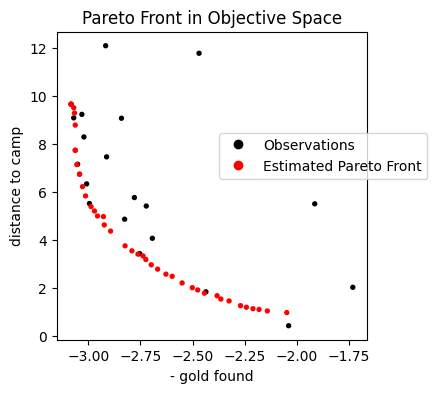

In [3]:
ProcessOptimizer.plot_Pareto(optimizer=opt, figsize = [4,4], objective_names=["- gold found", "distance to camp"]);

If you have ipyml installed, you can get the plot of the Pareto front interactive, where each point have a popup showing the control parameters producing the point when you hover over it with your mouse:

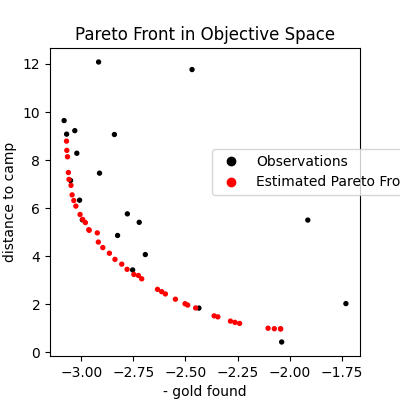

In [4]:
#ipympl is needed for the following cell to render. without ipympl, the user is still able to run po.plot_pareto(optimizer) but the plot will not be interactive.
%matplotlib widget
ProcessOptimizer.plot_Pareto(
    optimizer=opt,
    figsize = [4,4],
    objective_names=["- gold found", "distance to camp"],
    dimensions= ["E-W", "N-S"],
)